# Chess Upsets

# Goal: 
* Discover drivers of upsets in chess games played on Lichess.org
* Use drivers to develop a machine learning model to classify games as ending in upset or not ending in upset

# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

from scipy import stats
import re

import wrangle as w
import explore as e
import modeling as m

# Acquire

* Data acquired from [Kaggle](https://www.kaggle.com/datasnaek/chess)
* It contained 20,058 rows and 9 columns before cleaning
* Each row represents a chess game played on Lichess.org
* Each column represents a feature of those games

# Prepare

**Prepare Actions:**
* Removed columns that did not contain useful information
* Renamed columns to promote readability
* Checked for nulls in the data (there were none)
* Checked that column data types were appropriate
* Removed white space from values in object columns
* Added Target column 'upset' indicating weather the lower rated player won the game
* Added additional features to investigate:
    * Rating Difference
    * Game Rating
    * Lower Rated White
    * Time Control Group
    * Upset
* Encoded categorical variables
* Split data into train, validate and test (approx. 60/25/15), stratifying on 'upset'
* Scaled continuous variable
* Outliers have not been removed for this iteration of the project

# Data Dictionary

| Feature | Definition |
|:--------|:-----------|
|Rated| True or False, The game's result is reflected in each player's rating|
|Winning Pieces| The color of pieces the winning player was moving|
|White Rating| Rating of the player moving the white pieces using the Glicko-2 rating method for games played on Lichess|
|Black Rating| Rating of the player moving the white pieces using the Glicko-2 rating method for games played on Lichess|
|Rating Difference| The difference in rating between the players in the game|
|Game Rating| The average rating of the two players in the game|
|Lower Rated White| True or False, The lower rated player is moving the white pieces|
|Opening Name| The name of the opening played in the game|
|Time Control Group| The amount of time allotted to each player to make their moves, **Standard** (60 min or more), **Rapid** (30 - 15 min), **Blitz** (5 - 3 min), or **Bullet** (2 or less), **Other** (any other time limit)|
|Upset (Target)| True or False, The lower rated player won the game|
|Additional Features|Encoded and values for categorical data and scaled versions continuous data|


In [2]:
# acquiring, cleaning, and adding features to data
df = w.wrangle_chess_data(reprep = True)

# splitting data into train, validate, and test
train, validate, test = w.split_my_data(df)

# adding scaled columns of rating difference and game rating
train, validate, test = w.scale_data(train, validate, test)

## A brief look at the data

In [3]:
train.head()

,time_control_group,rated,winning_pieces,increment_code,white_rating,black_rating,opening_name,upset,rating_difference,game_rating,lower_rated_white,time_control_group_Blitz,time_control_group_Bullet,time_control_group_Other,time_control_group_Rapid,time_control_group_Standard,rating_difference_scaled,game_rating_scaled
0,Other,True,white,10+0,1393,1404,Philidor Defense #2,True,11,1398,True,0,0,1,0,0,0.007373,0.350814
1,Other,False,black,40+2,1505,1743,Italian Game: Classical Variation #2,False,238,1624,True,0,0,1,0,0,0.159517,0.487040
2,Other,True,black,10+0,1255,1626,Sicilian Defense: Smith-Morra Gambit #2,False,371,1440,True,0,0,1,0,0,0.248660,0.376130
3,Blitz,True,black,5+5,1540,1536,Queen's Pawn Game #3,True,4,1538,False,1,0,0,0,0,0.002681,0.435202
4,Other,True,black,10+0,1545,1890,King's Pawn Game: Mengarini's Opening,False,345,1717,True,0,0,1,0,0,0.231233,0.543098


## A summery of the data

In [23]:
train.describe()

,white_rating,black_rating,rating_difference,game_rating,time_control_group_Blitz,time_control_group_Bullet,time_control_group_Other,time_control_group_Rapid,time_control_group_Standard,rating_difference_scaled,game_rating_scaled
count,11232.000000,11232.000000,11232.000000,11232.000000,11232.000000,11232.000000,11232.000000,11232.000000,11232.000000,11232.000000,11232.000000
mean,1594.913907,1586.570869,172.938657,1590.494747,0.093038,0.007123,0.609598,0.275463,0.014779,0.115911,0.466844
std,289.825479,290.330461,178.637868,262.121537,0.290498,0.084098,0.487862,0.446767,0.120673,0.119730,0.158000
min,784.000000,789.000000,0.000000,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1398.000000,1388.000000,45.000000,1405.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030161,0.355033
50%,1564.000000,1559.000000,115.000000,1567.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.077078,0.452682
75%,1788.000000,1783.250000,241.000000,1769.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.161528,0.574442
max,2700.000000,2621.000000,1492.000000,2475.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Explore

## How often do upsets occur?

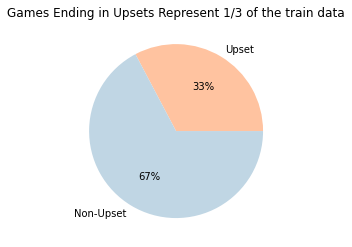

In [5]:
# get pie chart upsets
e.get_pie_upsets(train)

* About 1/3 of the games in the training data will end in upset

## Dose first move advantage effect upsets?

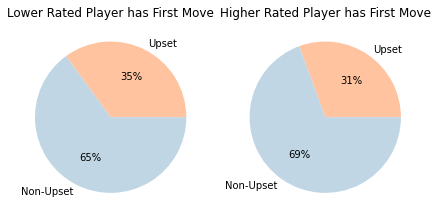

In [6]:
# get pie chart lower rated white
e.get_pies_white(train)

* Upset percentage is 4% higher in games where the lower rated player makes the first move.

**I will now use a chi-square test to investigate whether 'Upset' and "Lower Rated White" are related** 
* Traditionally the player moving the white pieces moves first
* I will use a confidence interval of 95% 
* The resulting alpha is .05<br>

**Ho: "Upset" and "Lower Rated White" are independent of one another.**<br>
**Ha: "Upset" and "Lower Rated White" are related.**

In [7]:
# get chi-square test
e.get_chi_white(train)

chi^2 = 24.9953
p     = 0.0000


**The p-value is greater than the alpha. Therefore, we have evidence to support that "Upset" and "Lower Rated White" are related. Based on this, and the 4% difference in upsets, observed in the train data, I believe that using the "Lower Rated White" feature in modeling will likely have a small positive impact on the model's accuracy.**

## Does a game being rated effect upsets?

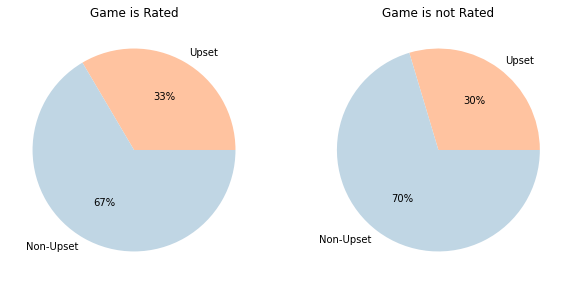

In [8]:
# get pie charts
e.get_pie_rated(train)

* Upset percentage is 3% higher in games that are rated

**I will now use a chi-square test to investigate weather "Upset" and "Rated" are related.**
* I will use a confidence interval of 95% 
* The resulting alpha is .05<br>

**Ho: "Rated" and "Upset" are independent of one another.** <br>
**Ha: "Rated" and "Upset" are related.**

In [9]:
# get chi-square results
e.get_chi_rated(train)

chi^2 = 11.7329
p     = 0.0006


**The p-value is less than the alpha. Therefore, we have evidence to support that "Upset" and "Rated" are related. Based on this and the 3% difference in upsets, observed in the train data, I believe that using the "Rated" feature in modeling will likely have a small positive impact on the model's accuracy.**

## Does player rating have an effect on upsets?


### 1) Does game rating (The average rating of both players in a game) have an effect on upsets? 

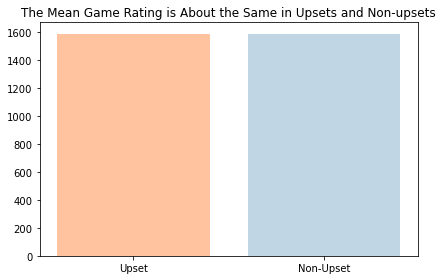

In [10]:
# get bar chart
e.get_game_rating(train)

* The average game rating for upsets is very similer to the average game rating for non-upsets

**Because the average game rating for games that end in upsets is very similar to the average game rating of games that do not end in upsets, it is not likely that "Game Rating" will be a useful feature to model on.**

### 2) Does the difference in player rating have an effect on upsets?

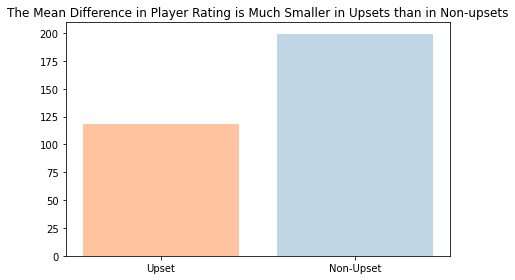

In [11]:
# get bar chart
e.ave_diff_rating(train)

* The average difference in player rating is 82 points lower in games ending in upset.

**I will now do a T-test to test for a significant difference between the mean difference in player rating of games ending in upset and the mean difference in player rating of games ending in non-upset.**

* I will use a confidence interval of 95%
* The resulting alpha is .05

**HO: The mean difference in player rating of games ending in upset is not significantly different from the mean difference in player rating of games not ending in an upset.** <br>
**HA: The mean difference in player rating of games ending in upset is significantly different from the mean difference in player rating of games not ending in an upset.**

In [12]:
# get T-test resul
e.get_t_rating_diff(train)

t = -23.2930
p = 0.0000


**The p-value is less than the alpha. Therefore, we have evidence to support that the mean rating difference of players in games ending in upset is significantly different from the mean rating difference of players in games that end in non-upsets. Based on this, and the 82 point difference in means, observed in the train data, I believe that using "Rating Difference" during modeling will provide a moderate improvement in the model's accuracy.** 

## Does time block effect upsets?

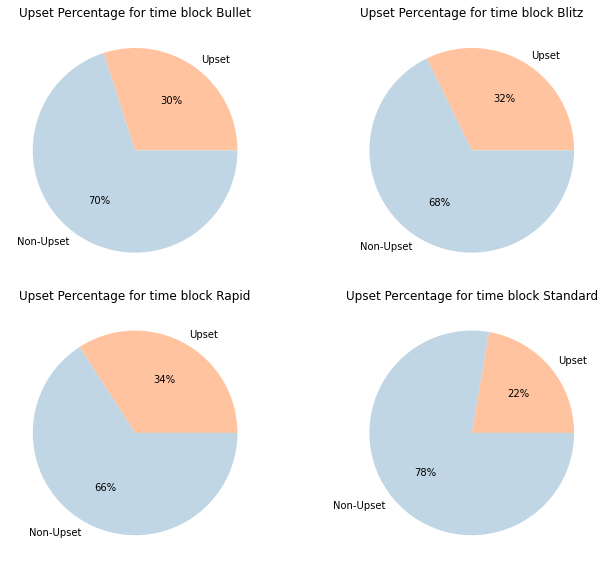

In [13]:
# Get pie charts
e.get_pie_time(train)

* In shorter time control groups where time is very limited, such as Bullet, Blitz, and Rapid games upset percentage ranges from 30 to 34%.
* In Standard, where time is more plentiful, upsets drop to 22%. 

**I will now perform a chi-square test to determine if "Upset" and "Time control Group" are independant.**
* I will use a confidence interval of 95%
* The resulting alpha is .05

**Ho: "Upset" and "Time Control Group" are independent of one another.** <br>
**Ha: "Upset" and "Time Control Group" are related.**

In [14]:
# get chi-square test
e.get_chi_time(train)

chi^2 = 11.5701
p     = 0.0209


**The p-value is less than the alpha. Therefore, we have evidence to support that "Time Control Group'' and "Upset" are related. Based on this, and the differences in upset percentages among the different time groups, I believe that having a standard time control is a driver of upsets. Adding an encoded version of this feature to the model will likely have a moderate positive effect on the model's accuracy.**

# Does opening effect upsets?

* There are 1236 unique openings identified in the training data
* This is too many for a thorough examination of each
* I will examine the top ten, by popularity

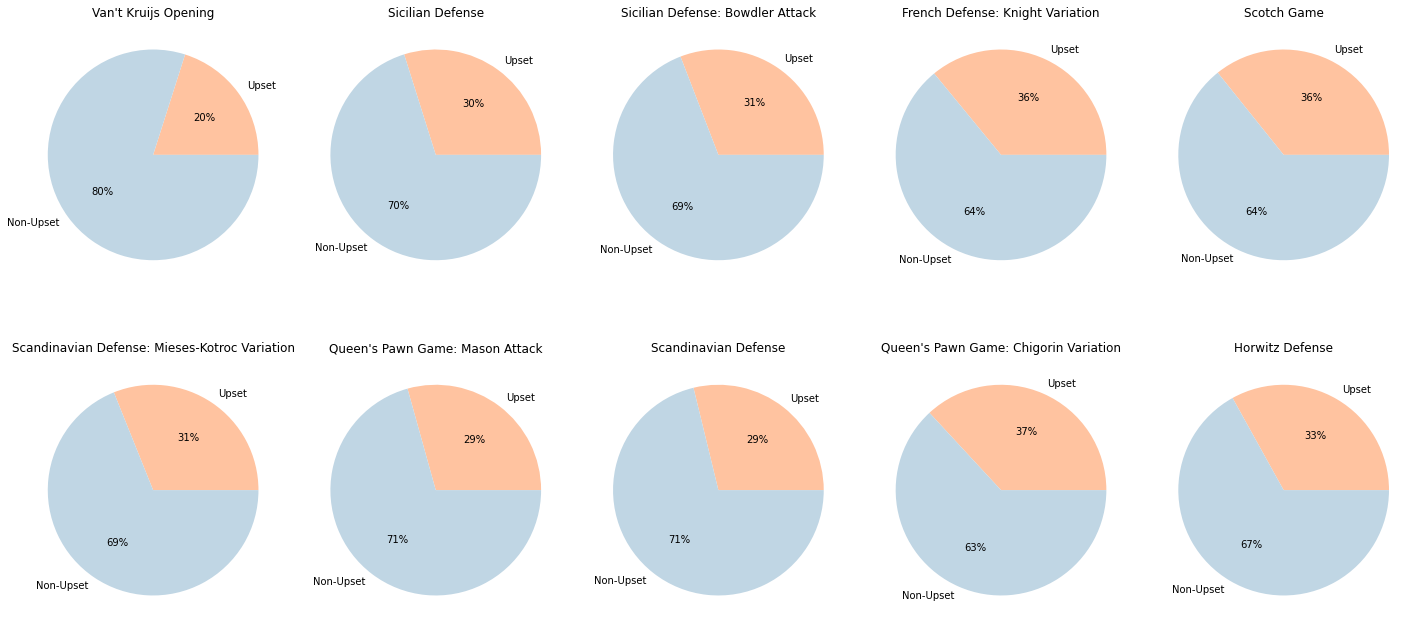

In [15]:
# get upset distributions of top ten most populer openings
e.get_pie_open(train)

* Percentage of upsets range from 20 - 37 among top openings

**I will now run a chi-square test to see if "Opening Name" and "Upset" are dependent on one another.**
* I will use a confidence interval of 95%
* The resulting alpha is .05

**Ho: "Opening Name" and "Upset" are independent of one another.** <br>
**Ha: "Opening Name" and "Upset" are dependent on one another.**

In [16]:
# get chi-square results
e.get_chi_open(train)

chi^2 = 1350.4134
p     = 0.0117


**The p-value is less than the Alpha. Therefore, we have evidence to support that "Opening Name" and "Upset" are related. However, there are over 1236 unique openings in “Opening Names.” Adding that number of encoded columns to the model would likely do more harm than good.**

# Exploration Summary

* "Lower Rated White" and "Rated" were each found to be drivers of "Upset"
    * Though the amount of influence each has is likely to be weak
* "Rating Difference" was found to be a driver of "Upset"
* "Time Control Group" was found to be a driver of "Upsets" 
    * Being in the standard time control or not seemed to have a particularly strong influence.
* "Opening Name" was found to be a driver of "Upsets" 
    * Upset percentage ranged from 20-37%
    * encoding all of these features would result in more noise than signal to the model
    * It may be possible to create groups of similar openings in order to make a more reasonable number features

<br>
* "Game Rating" was not found to be a driver of upsets
<br>

# Features I am moving to modeling With
* "Lower Rated White" (small difference in upset percentage, but relationship to upsets is statistically significant)
* "Rated" (small difference in upset percentage, but relationship to upsets is statistically significant)
* "Time Control standard" (moderate difference in upset percentage, and dependance is statistically significant)
* "Rating Difference" (Large difference in rating observed, and difference is significant)

# Features I'm not moving to modeling with
* "Opening" (Although found to be a driver of "upset" the encoding process would result in more noise than signal at this time)
* "Game Rating" (There is no evidence that "Game Rating" is a driver of upsets)

# Modeling
* I will use accuracy as my evaluation metric  
* non-upsets makeup 67% of the data 
 <br>
* by guessing non-upset for every game one could achieve an accuracy of 67%
* 67% will be the baseline accuracy I use for this project
 <br>
* I will be evaluating models developed using four different model types and various hyperparameter configurations 
* Models will be evaluated on train and validate data
* The model that performs the best will then be evaluated on test data 

In [17]:
# prep data for modeling
train_X, validate_X, test_X, train_y, validate_y, test_y = m.model_prep(train,validate,test)

## Decision Tree

In [18]:
# get decision tree results
m.get_tree(train_X, validate_X, train_y, validate_y)

Accuracy of Decision Tree on train data is 0.6728988603988604
Accuracy of Decision Tree on validate data is 0.6722060656418779


* Decision Tree accuracy is about equal to the baseline

## Random Forest

In [19]:
# get random forest results
m.get_forest(train_X, validate_X, train_y, validate_y)

Accuracy of Random Forest on train is 0.6726317663817664
Accuracy of Random Forest on validate is 0.6726215205650187


* Random Forest accuracy is about equal to the baseline

## Logistic Regression

In [20]:
# get logistic regression results
m.get_reg(train_X, validate_X, train_y, validate_y)

Accuracy of Logistic Regression on train is 0.6726317663817664
Accuracy of Logistic Regression on validate is 0.6726215205650187


* Logistic regression accuracy is about equal to the baseline


## KNN

In [21]:
# get knn results
m.get_knn(train_X, validate_X, train_y, validate_y)

Accuracy of Logistic Regression on train is 0.6823361823361823
Accuracy of Logistic Regression on validate is 0.6333610303282093


* Logistic regression accuracy is better than baseline on train, and worse than baseline on validate
* It is likely over-fit

# Comparing Models

* Decision Tree, Random Forest, and Logistic Regression models all performed about equal to baseline on train and validate
* The KNN model performed slightly better on train data but was worse on validate data. It is likely overfit.
* Because the results of the Decision Tree, Random Forest, and Logistic Regression models were all very similar I could proceed to test with any of these models.
* I have chosen to move forward with the Logistic Regression model

## Logistic Regression on Test

In [22]:
# get test results for final model
m.get_reg_test(train_X, test_X, train_y, test_y)

Accuracy of Logistic Regression on test is 0.6727318045862413


### Modeling Summary

* Decision Tree, Random Forest, and Logistic Regression models all performed about equal to baseline on train and validate
* The KNN model performed slightly better on train data but was worse on validate data. It is likely overfit.
* A Logistic Regression model selected as the final model and had an accuracy of about 67% which is about equal to the baseline accuracy

# Conclusions

### Exploration

* Upsets in chess occur in about 1/3 of games
* Games in which the lower rated player makes the first move, and games that are rated have a slightly higher chance of ending in an upset 
* Games ending in upset have a much lower mean difference in player rating than games not ending in upset
* Games using shorter time control, such as Bullet, Blitz, and Rapid games, have an upset percentage that closely mirrors the overall upset percentage ranging from 30-34% while standard games have a much lower upset percentage at 22%
* Looking at the top 10 openings in terms of frequency in the data set we can conclude that a given opening does affect the likelihood of a game ending in an upset. Upset percentages very by opening from 20-39%
* The average rating of players in a game has no provable effect on the chance of that game ending in upset

### Modeling

**The final model failed to significantly outperform the baseline. Possible reasons include:**
* “Rated” and “lower rated white” each only accounted for a small difference in the percentage of upsets
* While “Opening Name” seemed to be a significant driver of upsets. It contains 1200+ values that, once encoded, would add an overwhelming number of features to the model. 

### Recommendations

* To increase the skill intensity of a game add to the length of time players are able to consider their moves

### Next Steps
* Cluster together opening variants in "Opening Name" to reduce the number of features input into the model
* Look for other ways to describe "Opening Name" Such as by popularity of the opening or average rating of players playing that opening